# Dog Breeds Convolutional Classificator with TensorFlow

## Импорт библиотек

In [1]:
from google.colab import drive
import shutil
import zipfile
import os
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import pandas as pd

tf.test.gpu_device_name()

''

## Подключение GoogleDrive (Для Google Colab)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive


In [3]:
zip_file_path = '/content/drive/MyDrive/Datasets/StanfordDogs.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/StanfordDogs/'
with zipfile.ZipFile('/content/StanfordDogs.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['annotations', 'images']


## Валидация данных

In [4]:
def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                try:
                    img_raw = tf.io.read_file(filepath)
                    img = tf.io.decode_image(img_raw, channels=3)
                    img_jpeg = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                except (tf.errors.InvalidArgumentError, ValueError) as e:
                    print(f'Error with image {filepath}: {e}')
                    os.remove(filepath)  # Удаление проблемного изображения
    print('All images are fine')


check_images(unzip_dir)

All images are fine


## Разбиение и загрузка данных

In [5]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    '/content/StanfordDogs/images/Images',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='training',
    seed=1488
)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    '/content/StanfordDogs/images/Images',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='validation',
    seed=1488
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


## Построение модели

Модель будет дообучаться на модели MobileNetV3Small, обученной на основе набора данных ImageNet.

In [8]:
resnet50 = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
print(f'Base model (No top) layers count: {len(resnet50.layers)}')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Base model (No top) layers count: 175


In [9]:
resnet50.trainable = True

for layer in resnet50.layers[:-125]:
    layer.trainable = False

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = resnet50(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,143,096 (92.10 MB)

 Trainable params: 23,482,488 (89.58 MB)

 Non-trainable params: 660,608 (2.52 MB)

## Компиляция модели

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Создание обратных вызовов

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Models/dogbreeds.keras',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
		patience=3
    )
]

## Обучение модели

In [12]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
  3/515 ━━━━━━━━━━━━━━━━━━━━ 2:38:12 19s/step - accuracy: 0.0069 - loss: 5.9829    

KeyboardInterrupt: 

## Визуализация обучения

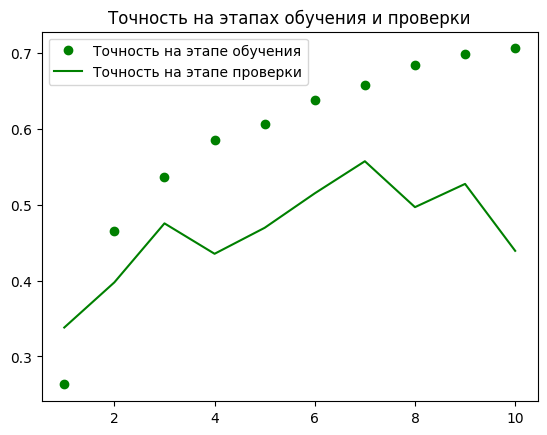

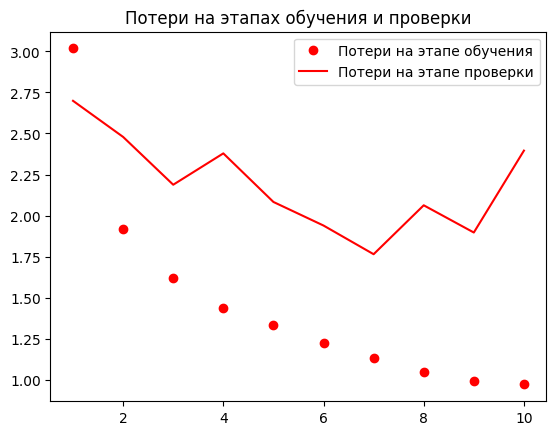

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Тестирование модели

In [ ]:
test_model = keras.models.load_model('/content/drive/MyDrive/Models/dogbreeds.keras')
test_loss, test_acc = test_model.evaluate(validation_dataset)
print(f'Test accuracy: {test_acc:.3f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5407 - loss: 1.8438
Test accuracy: 0.557


## Просмотр формата предсказаний

In [ ]:
prediction = test_model.predict(validation_dataset.take(1))
print(f'Prediction format: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction format: [[4.6039485e-08 7.3529543e-07 6.8116467e-03 ... 8.8948508e-11
  2.5817724e-09 1.2942779e-09]
 [2.5699677e-02 2.2415513e-07 7.9488891e-06 ... 1.8708826e-04
  4.4729793e-05 5.0824849e-07]
 [1.2280194e-04 3.4169011e-06 4.3340738e-06 ... 4.7125592e-04
  1.8741387e-04 2.0586337e-07]
 ...
 [1.4505527e-10 2.7326493e-11 3.6552215e-09 ... 2.0105903e-12
  9.3780747e-11 2.4031920e-12]
 [1.0077413e-07 4.2341355e-07 1.9790743e-06 ... 1.5093863e-07
  1.9394513e-07 9.1409667e-08]
 [1.4609864e-08 1.6285705e-05 1.0402443e-07 ... 5.5157876e-08
  7.5007488e-06 7.2859807e-06]]


## Сохранение списка меток

In [ ]:
class_names = train_dataset.class_names
classes_df = pd.DataFrame(class_names, columns=['Classes'])
classes_df